# Goal:

* Basic assessment on whether the diffusive boundary layer of the ultracentrifugation tubes may be causing the broad OTU abundance distributions (most span the entire gradient)

# Literative on diffusive boundary layers (DBL)

## DNA binding to plastics

* [blog on adsorbtion](http://core-genomics.blogspot.com/2014/03/how-long-can-you-store-your-ngs.html)
  * 5-25% DNA adsorbed to polypropylene
  * [Belotserkovkii](http://www.ncbi.nlm.nih.gov/pubmed/8539626)
  * [whitepaper](https://www.researchgate.net/publication/228649995_Avoiding_DNA_loss_and_denaturation_upon_storage_in_plastic_microtubes)
  * [Gaillard and Strauss](http://www.sciencedirect.com/science/article/pii/S1366212008701016)
* http://www.sciencedirect.com/science/article/pii/S0003269703000514
* http://ac.els-cdn.com/S0003269785712717/1-s2.0-S0003269785712717-main.pdf?_tid=5920ba7a-9acf-11e5-94e8-00000aacb362&acdnat=1449265285_3576aa92de9eb1df4e7f299ef05389ff
* Beckman ultra-cfg tubes:
  * http://www.centrifugebybeckman.com/?page_id=788/?pi_ad_id=62362322836&gclid=CLHP0c3gxckCFYQfHwodfp8CBg
  * surface properties to 'prevent adherence of nucleic acids and proteins'
  
## Diffusion of DNA 

* http://www.pnas.org/content/103/19/7310.full.pdf
  * $D \sim L^{-v}$
    * $v_L$ = 0.571 +/- 0.014
      * linear DNA
    * L in microns
    * D = uM^2/sec

# Init

In [10]:
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [11]:
%%R
library(readxl)
library(dplyr)
library(tidyr)
library(ggplot2)
library(rootSolve)

# Setting parameters

In [12]:
%%R
SIPdbFile = '/home/nick/db/SIPdb/DOE_SIP_db.xlsx'
sheet.id = 'Fractions'

In [13]:
%%R

# tube characteristics
tube_diam__mm = 13
tube_height__mm = 48
tube_round_bottom_height__mm = 6.5
tube_capacity__ml = 4.7
tube_composition = 'polypropylene'

# rotor 
rotor_id = 'TLA-110'
r_min__mm = 26
r_ave__mm = 37.2
r_max__mm = 48.5
frac_tube_angle = 90 

# cfg run
## rpm of run
rpm = 55000
## angular velocity (w^2)
angular_velocity = 17545933.74
## average particle density
ave_gradient_density = 1.70
## beta^o  
BetaO = 1.14e9  # CsCl at density of 1.70
## position of particle at equilibrium 
particle_at_eq = 3.78 
## max 13C shift
max_13C_shift_in_BD = 0.036
## min BD (that we care about)
min_GC = 13.5
min_BD = min_GC/100.0 * 0.098 + 1.66
## max BD (that we care about)
max_GC = 80
max_BD = max_GC / 100.0 * 0.098 + 1.66    # 80.0% G+C
max_BD = max_BD + max_13C_shift_in_BD

# diffusive boundary layer (DBL)
DBL_size_range__micron = c(10,100)


# misc
fraction_vol__cm3 = 0.1

In [14]:
%%R
# rotor angle
## sin(x) = opp / hypo
## x = sin**-1(opp/hypo)

rad2deg = function(rad) {
    return((180 * rad) / pi)
}
deg2rad = function(deg){
    return(deg * pi / 180)
}


x = r_max__mm - r_min__mm 
hyp = tube_height__mm
rotor_tube_angle = rad2deg(asin(x / hyp))
cat("Tube angle from axis of rotation:", rotor_tube_angle, "\n")

Tube angle from axis of rotation: 27.95319 


In [15]:
%%R
x = r_max__mm - r_min__mm 
hyp = tube_height__mm
asin(x / hyp)

[1] 0.4878751


## Isoconcentration point 

* Formula 6.7 in Birnine and Rickwood 1978

In [165]:
%%R
# isoconcentration point
r_top = r_min__mm / 10
r_bottom = r_max__mm / 10
I__cm = sqrt((r_top**2 + r_top * r_bottom + r_bottom**2)/3)

cat('Isoconcentration point:', I__cm, '(cm)\n')

Isoconcentration point: 3.781204 (cm)


## Fraction size range (based on previous run data)

In [166]:
%%R
# loading SIPdb info
df.SIPdb = read_excel(SIPdbFile, sheet=sheet.id)
df.SIPdb %>% head(n=3) %>% as.data.frame 

      sample_id gradient_date fractionation_date fraction_id well_id     RI
1 13C-Ami.D3.R1    2015-01-27         2015-01-30           1      A1 1.4075
2 13C-Ami.D3.R1    2015-01-27         2015-01-30           2      B1 1.4071
3 13C-Ami.D3.R1    2015-01-27         2015-01-30           3      C1 1.4067
  RI_corrected       BD volume experiment
1       1.4059 1.770113     NA    fullCyc
2       1.4055 1.765742     NA    fullCyc
3       1.4051 1.761371     NA    fullCyc


    Min.  1st Qu.   Median     Mean  3rd Qu.     Max.     NA's 
-0.00219  0.00328  0.00437  0.00440  0.00546  0.01748      120 


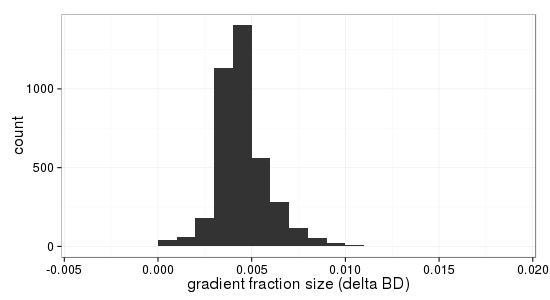

In [167]:
%%R -w 550 -h 300
# BD range
df.SIPdb = df.SIPdb %>%
    group_by(sample_id, fractionation_date) %>%
    arrange(fraction_id) %>%
    mutate(BD_range = BD - lead(BD)) 

df.SIPdb$BD_range %>% summary %>% print

ggplot(df.SIPdb, aes(BD_range)) + 
    geom_histogram(binwidth=0.001) +
    labs(x = 'gradient fraction size (delta BD)') +
    theme_bw() +
    theme(
        text = element_text(size=16)
    )

In [168]:
%%R
# fraction size range (1st & 3rd quartiles)
frac_size_range__BD = c(0.003, 0.005)

## band width distribution

* tube height of fraction = volume of fraction 

$100 ul = 0.1 cm^3$

$v = pi*r^2*h$

$h = v / (pi * r^2)$

In [169]:
%%R
frac_size__ul = 100
frac_vol__cm3 = frac_size__ul / 1000
tube_radius__cm = tube_diam__mm / (2 * 10)
frac_height = frac_vol__cm3 / (pi * tube_radius__cm **2)
cat('The height of each fraction in vertically oriented tube:', frac_height, '(cm)\n')
cat('(Just applies to cylinder)\n')

The height of each fraction in vertically oriented tube: 0.07533962 (cm)
(Just applies to cylinder)


In [170]:
%%R
# round bottom volume = (4/3 * pi * r**3) / 2
tube_radius__cm = tube_diam__mm / (2*10)
bottom_volume__cm3 = (4/3 * pi * tube_radius__cm**3) / 2
cat('Tube bottom volume:', bottom_volume__cm3, '(cm^3)\n') 
cat('Number of fractions in tube bottom:', bottom_volume__cm3 / 0.1, '\n')

Tube bottom volume: 0.5751733 (cm^3)
Number of fractions in tube bottom: 5.751733 


In [171]:
%%R
df.SIPdb.f = df.SIPdb %>%
    filter(BD <= max_BD) %>%
    arrange(fraction_id) %>%
    group_by(sample_id, fractionation_date) %>%
    summarize(BD_heaviest = first(BD)) %>% head %>% print


Error in summarize(., BD_heaviest = first(BD)) : 
  argument "by" is missing, with no default


/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: 1: Removed 107 rows containing missing values (geom_point). 

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: 2: Removed 8 rows containing missing values (geom_path). 

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: 3: Removed 8 rows containing missing values (geom_point). 

  res = super(Function, self).__call__(*new_args, **new_kwargs)


In [172]:
%%R 
# plotting fraction vs fraction height in verticle tube
## calculating culmulative fraction height
df.SIPdb = df.SIPdb %>%
    ungroup() %>%
    mutate(frac_height = frac_height) %>%
    group_by(sample_id, fractionation_date) %>%
    arrange(fraction_id) %>%
    mutate(cum_frac_height = cumsum(frac_height))

## first fraction kept (max BD fraction used for each gradient)
heavy.frac = df.SIPdb %>%
    filter(BD <= max_BD) %>%
    arrange(fraction_id) %>%
    group_by(sample_id, fractionation_date) %>%
    summarize(BD_heaviest = first(BD))
heavy.frac = inner_join(heavy.frac, df.SIPdb, c('sample_id' = 'sample_id',
                                        'fractionation_date' = 'fractionation_date',
                                        'BD_heaviest' = 'BD')) %>%
    select(sample_id, fractionation_date, BD_heaviest, cum_frac_height, BD_range, fraction_id) 


## plotting
ggplot(df.SIPdb, aes(cum_frac_height, BD_range)) +
    geom_density2d() +
    geom_rug(data=heavy.frac, sides='b', size=1, alpha=0.25, aes(color=fraction_id)) +
    #geom_point(alpha=0.25) +
    #stat_smooth(formula= y ~ poly(x, 2), method='lm') +
    labs(x='Height of fraction\nfrom tube bottom (cm)', y='BD span of fraction') +
    theme_bw() +
    theme(
        text = element_text(size=16)
    )


Error in summarize(., BD_heaviest = first(BD)) : 
  argument "by" is missing, with no default


In [173]:
%%R
# summary of where in tube the heaviest fraction is used (cm from the bottom)
heavy.frac$cum_frac_height %>% summary %>% print
heavy.frac$fraction_id %>% summary %>% print

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
0.07534 0.37670 0.37670 0.39240 0.45200 0.52740 
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  1.000   5.000   5.000   5.208   6.000   7.000 


#### Figure description:

* rug plot is showing the heaviest gradient fraction actually used further in SIP pipeline

#### Notes: 

* similar to Flamm et al., 1972 on fixed angle rotors
* near the bottom of the tube, the density changes most rapidly
  * smaller bandwidths at bottom of the tube

## Converting verticle bandwidth to angled bandwidth

* Flamm et al., 1966

Width of band in angled rotor (at speed):
 
$w = \frac{V}{\pi*r*b}$

Width of band in vertical position:

$w' = \frac{V}{\pi*r^2}$

Where:

* V = common volume
* r = tube radius
* b = band ellipse major axis (at speed)

# surface to volume ratio of each fraction

## Rough approximation

In [174]:
%%R
frac_size__mm = 1
tube_diam__mm = 13
DBL_size__mm = 0.1

In [175]:
%%R
tube_circ = 2 * pi * tube_diam__mm**2
nonDBL_circ = tube_circ - 2 * DBL_size__mm
frac_vol = tube_circ * frac_size__mm
nonDBL_vol = nonDBL_circ * frac_size__mm
DBL_vol = frac_vol - nonDBL_vol
DBL_to_frac = DBL_vol / frac_vol * 100

cat('Percent of fraction that is DBL: ', DBL_to_frac, '%\n', sep='')

Percent of fraction that is DBL: 0.0188349%


# Stability of gradient

$t = 0.3(r_b - r_t)^2$

* r unit: cm
* t unit: hours

In [176]:
%%R
r_t = r_min__mm / 10
r_b = r_max__mm / 10
t = 0.3 * (r_b - r_t)**2
cat('Time span of stability:', t, '(h)\n')

Time span of stability: 1.51875 (h)


# Tube position of fraction (during spin; at equilibrium)

* angled tube: this sets up the diffusive boundary layer
* Determining tube location of each density band:
  * For density range of interest:
    * determine location range in tube
* Determining where each density band touched on the tube during ultracentrifugation:
  * gradient is basically a set of ellipsoids (angled cross sections) of the tube (cylinder)
    * Need to determine the ellipsoid main axis diameter for each position in the gradient
  * For each location range in tube (see above):
    * Determine the ellipsoid major axis length
    * Determine the tube side wall locations (bottom & top) for the ellipsoid
      * This is the location of the diffusive boundary layer for the ellispoid

## Tube location of each density band

Density at a given radius from axis of rotation:

$ x = \big(\frac{w^2}{2*\beta^o} * (r_d^2 - I^2)\big) + D$

* where:
  * $x$ = density at a given radius
  * $w^2$ = angular velocity
  * $\beta^o$ = beta coef
  * $r_d$ = radius of desired density (cm)
  * $I$ = isocencentration point (cm)
  * $D$ = average density of gradient
  

Radius from axis of rotation for a given density:

$ r_d = \sqrt{\frac{(x - D) * 2\beta^o}{w^2} + I^2} $





In [177]:
%%R
BD2radius = function(x, D, BetaO, w2, I){
    sqrt( ((x-D)*2*BetaO/w2) + I^2)
}
  
min_BD_r = BD2radius(min_BD, ave_gradient_density, BetaO, angular_velocity, I__cm)
max_BD_r = BD2radius(max_BD, ave_gradient_density, BetaO, angular_velocity, I__cm)

cat('isoconcentration point:', I__cm, '\n')
cat('radius range for BD-min to BD-max: ', min_BD_r, 'to', max_BD_r, '\n')

isoconcentration point: 3.781204 
radius range for BD-min to BD-max:  3.289207 to 4.895445 


## Geometry of a angled cross sections in the ultracentrifugation tube

In [178]:
%%R
tube_diam__cm = tube_diam__mm / 10
elps_main_axis__cm = tube_diam__cm / deg2rad(rotor_tube_angle) 
cat('ellipsoid major axis length in tube (cylinder) cross section:', elps_main_axis__cm, '(cm)\n')

ellipsoid major axis length in tube (cylinder) cross section: 2.664616 (cm)


In [179]:
%%R
# radius position where rounded tube bottom affects ellipsoid major axis 
## should just be round bottom diameter
round_bottom_diam__cm = tube_diam__mm / 10
r_round_bottom = r_max__mm / 10 - round_bottom_diam__cm
cat('radius position where round bottom comes into play:', r_round_bottom, '\n')

radius position where round bottom comes into play: 3.55 


#### Notes:

* Need to take into account round bottom because it falls into the radius range for BD min-max

## Tube position of band (angled tube top & bottom) as a function distance from axis of rotation

>Thanks Sam!

In [180]:
%%R
## Equation for lower point of band in the rounded part of tube
distFromAxis2angleTubePosNEW = function(x, r, D, A){
  # x = a distance from the axis of rotation
  # r = radius of cfg tube
  # D = max tube distance from axis of rotation
  # A = angle of tube to axis of rotation (degrees)
  
# Equation for finding the lower point of the band  
  if(x >= D-(r*aspace::cos_d(A))-r) {
    d = x-(D-r)
    a = A-aspace::asin_d(d/r)
    LowH = r-r*aspace::cos_d(a)
    #print(LowH)                ## This band will be in the rounded part
  }else{
    d = D-(r*aspace::cos_d(A))-r-x
    hc = d/aspace::sin_d(A)
    LowH = r+hc
  # print(LowH)                 ## This band will be in the cylinder part
}

# Equation for finding the upper band
  if(x > D-(r-r*aspace::cos_d(A))) {
    d = x-(D-r)
    a = (A)-(180-aspace::asin_d(d/r))
    HighH = r-r*aspace::cos_d(a)
    #print(HighH)                ## This band will be in the rounded part
  }else{
    d = D-(r-r*aspace::cos_d(A))-x
  hc = d/aspace::sin_d(A)
  HighH = r+hc
  #print(HighH)                ## This band will be in the cylinder part
}
  
  return(c(LowH, HighH))
}


In [181]:
%%R
## Equation for lower point of band in the rounded part of tube
vertTube2PosdistFromAxis2 = function(y, r, D, A){
  # y = a distance from bottom of tube
  # r = radius of cfg tube
  # D = max tube distance from axis of rotation
  # A = angle of tube to axis of rotation (degrees)
  
    # Equation for finding the light contaminants
    if(y <= r) {
        a = (A+90)-aspace::acos_d((r-y)/r)
        x = r*aspace::cos_d(a)
        LightX = (D-r)-x
    }else{
        hc = y-r
        d = hc*aspace::sin_d(A)
        LightX = (D-r)-(r*aspace::cos_d(A))-d
    }
    
    # Equation for finding the heavy contaminants
    if(y <= r) {
        a = (90-A)-aspace::acos_d((r-y)/r)
        x = r*aspace::cos_d(a)
        HeavyX = (D-r)+x
    }else{
        hc = y-r
        d = hc*aspace::sin_d(A)
        HeavyX = D-(r-r*aspace::cos_d(A))-d
    }
    return(c(LightX, HeavyX))
}

R = tube_diam__mm / (2*10)
Dmax = r_max__mm / 10
TestY = 3
x = vertTube2PosdistFromAxis2(TestY,R,Dmax,rotor_tube_angle)
x %>% print

[1] 2.524272 3.672603


## tube\_band\_position ~ BD

* For tube in rotor with gradient at equilibrium, where on the tube height does each gradient band touch
  * Both bottom of tube and top 
  
  ~~~
         /  /
  top-->/  /
       /| /
      / |/
     (  /<--bottom
      ^^
~~~      
      

In [182]:
%%R
# params
tube_radius__cm = tube_diam__mm / (2*10)
tube_radius__cm %>% print
r_max__cm = r_max__mm / 10
## sequence of BD values in gradient
BDs = seq(min_BD, max_BD, 0.001)
## converting BD to position in gradient (assuming equilibrium)
rads = sapply(BDs, BD2radius, 
              D=ave_gradient_density, 
              BetaO=BetaO, 
              w2=angular_velocity, 
              I=I__cm)
# converting to band position in gradient to position in vertical tube height
angle.tube.pos = sapply(rads, distFromAxis2angleTubePosNEW, 
                        r=tube_radius__cm, 
                        D=r_max__cm, 
                        A=rotor_tube_angle)
angle.tube.pos = angle.tube.pos %>% t %>% as.data.frame
colnames(angle.tube.pos) = c('tube_low__cm', 'tube_high__cm')
angle.tube.pos$BD = BDs
angle.tube.pos$particle_pos = rads 
angle.tube.pos %>% head

[1] 0.65
  tube_low__cm tube_high__cm      BD particle_pos
1     1.368140      3.817911 1.67323     3.289207
2     1.326125      3.775896 1.67423     3.308901
3     1.284360      3.734131 1.67523     3.328479
4     1.242838      3.692609 1.67623     3.347942
5     1.201557      3.651328 1.67723     3.367293
6     1.160511      3.610282 1.67823     3.386533


In [183]:
%%R
Heights = seq(0, 4, 0.001)
Fractions = sapply(Heights, vertTube2PosdistFromAxis2,
                     r=tube_radius__cm, 
                     D=r_max__cm, 
                     A=rotor_tube_angle)
Fractions = Fractions %>% t %>% as.data.frame
colnames(Fractions) = c('Light', 'Heavy')
TestData = cbind (Fractions,Heights)
TestData %>% print


        Light    Heavy Heights
1    4.504687 4.504687   0.000
2    4.472382 4.536055   0.001
3    4.458743 4.548757   0.002
4    4.448181 4.558382   0.003
5    4.439213 4.566412   0.004
6    4.431264 4.573423   0.005
7    4.424042 4.579708   0.006
8    4.417369 4.585443   0.007
9    4.411133 4.590742   0.008
10   4.405253 4.595684   0.009
11   4.399673 4.600327   0.010
12   4.394348 4.604714   0.011
13   4.389245 4.608880   0.012
14   4.384336 4.612851   0.013
15   4.379601 4.616649   0.014
16   4.375020 4.620293   0.015
17   4.370578 4.623797   0.016
18   4.366264 4.627174   0.017
19   4.362065 4.630435   0.018
20   4.357973 4.633589   0.019
21   4.353980 4.636645   0.020
22   4.350077 4.639610   0.021
23   4.346260 4.642490   0.022
24   4.342521 4.645291   0.023
25   4.338857 4.648018   0.024
26   4.335263 4.650675   0.025
27   4.331734 4.653266   0.026
28   4.328267 4.655796   0.027
29   4.324859 4.658266   0.028
30   4.321506 4.660682   0.029
31   4.318206 4.663044   0.030
32   4.3

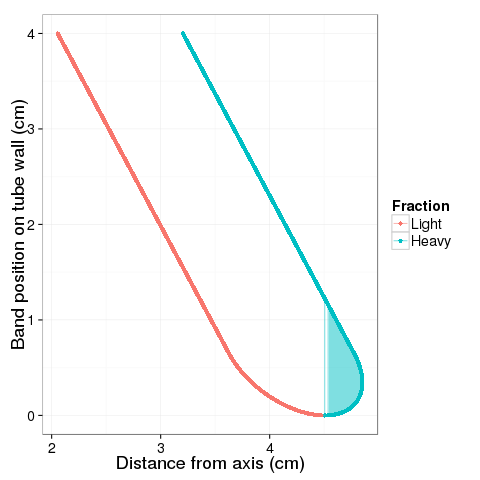

In [184]:
%%R
TestData.g = TestData %>%
    gather(Fraction, Fraction_X, Light, Heavy)

ggplot(TestData.g, aes(Fraction_X, Heights, color=Fraction)) +
    geom_point() +
    geom_line(alpha=0.5) +
    labs(x='Distance from axis (cm)', y='Band position on tube wall (cm)') +
    theme_bw() +
    theme(
        text = element_text(size=18)
    )

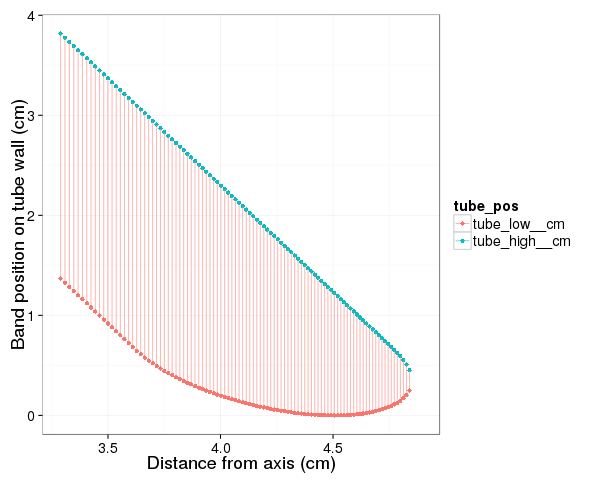

In [185]:
%%R -w 600
# plotting
angle.tube.pos.g = angle.tube.pos %>%
    gather(tube_pos, tube_pos__cm, tube_low__cm, tube_high__cm)

ggplot(angle.tube.pos.g, aes(particle_pos, tube_pos__cm, color=tube_pos, group=BD)) +
    geom_point() +
    geom_line(alpha=0.5) +
    labs(x='Distance from axis (cm)', y='Band position on tube wall (cm)') +
    theme_bw() +
    theme(
        text = element_text(size=18)
    )

## Misc

In [186]:
%%R
frac_size__ul = 100
frac_vol__cm3 = frac_size__ul / 1000
tube_radius__cm = tube_diam__mm / (2 * 10)
frac_height = frac_vol__cm3 / (pi * tube_radius__cm **2)
cat('The height of each fraction in vertically oriented tube:', frac_height, '(cm)\n')
cat('(Just applies to cylinder)\n')

The height of each fraction in vertically oriented tube: 0.07533962 (cm)
(Just applies to cylinder)


In [187]:
%%R
# round bottom volume = (4/3 * pi * r**3) / 2
tube_radius__cm = tube_diam__mm / (2*10)
bottom_volume__cm3 = (4/3 * pi * tube_radius__cm**3) / 2
cat('Tube bottom volume:', bottom_volume__cm3, '(cm^3)\n') 
cat('Number of fractions in tube bottom:', bottom_volume__cm3 / 0.1, '\n')

# need to determine the tube height of each of these first 6 fractions

Tube bottom volume: 0.5751733 (cm^3)
Number of fractions in tube bottom: 5.751733 


In [188]:
%%R
df.SIPdb.f = df.SIPdb %>%
    filter(BD <= max_BD) %>%
    arrange(fraction_id) %>%
    group_by(sample_id, fractionation_date) %>%
    summarize(BD_heaviest = first(BD)) %>% head %>% print


Error in summarize(., BD_heaviest = first(BD)) : 
  argument "by" is missing, with no default


# Tube position of fraction in vertical position

* For each density band:
  * Determine the height in the tube
  * This will rely on empirical data to determine the relationship between BD and tube height (vertical position)

## Relationship between density and tube height

* volume ~ BD
* tube height ~ volume

### tube height ~ volume

Cylinder volume:

$v = \pi r^2$ h

Sphere volume:

$v = \frac{4}{3} \pi r^3$

Spherical cap volume:

$V = \frac{\pi * h^2}{3} (3r-h)$

[1] 0.2360648


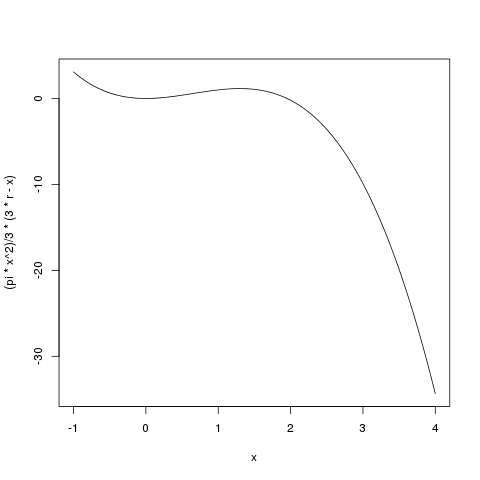

In [189]:
%%R 
# relationship: volume ~ height
r = 0.65

f = function(x){x**3 - 3*r*x**2 + 3*0.1/pi}
uniroot.all(f, c(0, r*2)) %>% print
curve((pi*x**2)/3 * (3*r - x), from=-1, to=4)

In [190]:
%%R
# converting cylinder volume to cylinder height (cm)
cyl_vol2height = function(v, r){v / (pi * r**2)}

cyl_vol2height(0.1, 0.65)

[1] 0.07533962


In [191]:
%%R
# converting sphere cap volume to sphere height (cm)
sphr_vol2height = function(v, r){
    # h**3 - 3*r*h**2 + (3v / pi) = 0
    f = function(x){x**3 - 3*r*x**2 + 3*v/pi}
    roots = uniroot.all(f, c(0, r*2))
    if(length(roots) > 1){
        root_str = paste(roots, sep=',')
        cat('ERROR: Number of roots > 1 for volume:', v, '\n roots:', root_str, '\n')
        stop()
    } else if (length(roots) == 0){
        cat('WARNING: no roots for volume:', v, '\n')
        roots = NA
    }
    return(roots[1])
}

sphr_vol2height(0.1, 0.65)

[1] 0.2360648


In [192]:
%%R
# -- check on calculation of sphere hight from bottom --
# height of rounded tube bottom 
h_bottom = tube_diam__mm / (2*10)
# volume of rounded portion of tube
v_bottom = (4/3 * pi * h_bottom**3)/2

stopifnot(sphr_vol2height(v_bottom, 0.65) == h_bottom)

In [193]:
%%R

# function to convert volume filling cfg tube to tube height
tubeVol2height = function(v, r=0.65){
    # v = volume (cm^3)
    # r = sphere radius
    stopifnot(length(v) == 1)
    
    sphr_cap_vol = (4/3 * pi * r**3)/2
    
    if(v <= sphr_cap_vol){
        # height does not extend to cylinder
        h = sphr_vol2height(v, r)
    } else {
        # height = sphere_cap + cylinder
        sphr_cap_height = sphr_vol2height(sphr_cap_vol, r)
        h =  sphr_cap_height + cyl_vol2height(v - sphr_cap_vol, r)
    }
    return(h)
}


# test
tube_radius__cm = tube_diam__mm / (2*10)
vol = 0.1   # 100 ul

vols = seq(0, 4, 0.1)
sapply(vols, tubeVol2height, r=tube_radius__cm)

 [1] 0.0000000 0.2360648 0.3449723 0.4348016 0.5161206 0.5932149 0.6687044
 [8] 0.7440440 0.8193836 0.8947232 0.9700628 1.0454025 1.1207421 1.1960817
[15] 1.2714213 1.3467609 1.4221006 1.4974402 1.5727798 1.6481194 1.7234590
[22] 1.7987986 1.8741383 1.9494779 2.0248175 2.1001571 2.1754967 2.2508364
[29] 2.3261760 2.4015156 2.4768552 2.5521948 2.6275344 2.7028741 2.7782137
[36] 2.8535533 2.9288929 3.0042325 3.0795722 3.1549118 3.2302514


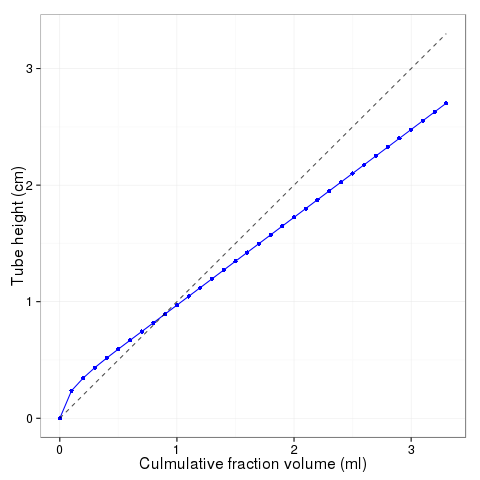

In [194]:
%%R
# plotting

n_fracs = 32
x = seq(0, 0.1*(n_fracs+1), 0.1)
df = data.frame('x' = x, 'y' = sapply(x, tubeVol2height))
ggplot(df, aes(x, y)) +
    geom_point(color='blue') +
    geom_line(color='blue') +
    stat_function(fun = function(x) x, linetype='dashed', alpha=0.7) +
    labs(x='Culmulative fraction volume (ml)',
         y='Tube height (cm)') +
    theme_bw() +
    theme(
        text = element_text(size=16)
    )

### fraction volume ~ BD

* determining from empirical data

In [195]:
%%R
# loading SIPdb info
df.SIPdb = read_excel(SIPdbFile, sheet=sheet.id)
df.SIPdb %>% head(n=3) %>% as.data.frame 

      sample_id gradient_date fractionation_date fraction_id well_id     RI
1 13C-Ami.D3.R1    2015-01-27         2015-01-30           1      A1 1.4075
2 13C-Ami.D3.R1    2015-01-27         2015-01-30           2      B1 1.4071
3 13C-Ami.D3.R1    2015-01-27         2015-01-30           3      C1 1.4067
  RI_corrected       BD volume experiment
1       1.4059 1.770113     NA    fullCyc
2       1.4055 1.765742     NA    fullCyc
3       1.4051 1.761371     NA    fullCyc


In [196]:
%%R
# BD range
df.SIPdb = df.SIPdb %>%
    group_by(sample_id, fractionation_date) %>%
    arrange(fraction_id) %>%
    mutate(BD_range = BD - lead(BD)) 

In [197]:
%%R
# round bottom volume = (4/3 * pi * r**3) / 2
tube_radius__cm = tube_diam__mm / (2*10)
bottom_volume__cm3 = (4/3 * pi * tube_radius__cm**3) / 2
cat('Tube bottom volume:', bottom_volume__cm3, '(cm^3)\n') 
cat('Number of fractions in tube bottom:', bottom_volume__cm3 / 0.1, '\n')

Tube bottom volume: 0.5751733 (cm^3)
Number of fractions in tube bottom: 5.751733 


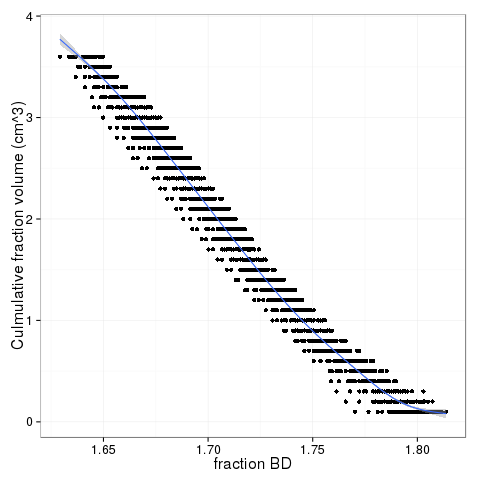

In [198]:
%%R 
# plotting fraction vs fraction height in verticle tube
## calculating culmulative fraction height

df.SIPdb = df.SIPdb %>%
    ungroup() %>%
    mutate(frac_vol = fraction_vol__cm3) %>%  
    group_by(sample_id, fractionation_date) %>%
    arrange(fraction_id) %>%
    mutate(culm_frac_vol = cumsum(frac_vol))

## plotting
ggplot(df.SIPdb, aes(BD, culm_frac_vol)) +
    geom_point() +
    geom_smooth() +
    labs(y='Culmulative fraction volume (cm^3)', x='fraction BD') +
    theme_bw() +
    theme(
        text = element_text(size=16)
    )


Call:
lm(formula = y ~ x + I(x^2) + I(x^3), data = dataset)

Coefficients:
(Intercept)            x       I(x^2)       I(x^3)  
    -2761.6       4943.8      -2931.8        576.5  



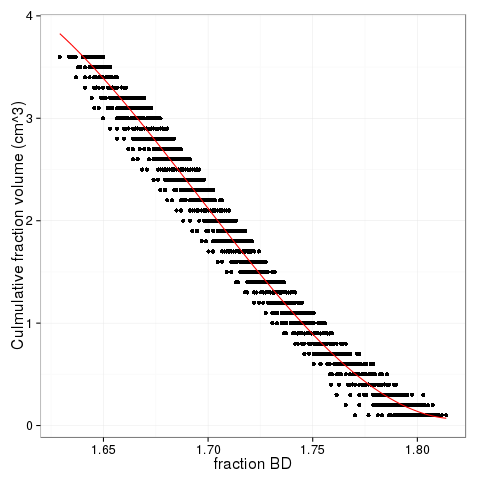

In [199]:
%%R 
# curve fit for: culm_frac_vol ~ fraction_BD

dataset = df.SIPdb %>%
    select(BD, culm_frac_vol) %>%
    rename('x' = BD, 'y' = culm_frac_vol) %>%
    as.data.frame

fit = lm(y~x+I(x^2)+I(x^3), data=dataset)
fit %>% print
dataset$y_pred = predict(fit)

ggplot(dataset, aes(x)) +
    geom_point(aes(y=y)) +
    geom_line(aes(y=y_pred), color='red') +
    labs(y='Culmulative fraction volume (cm^3)', x='fraction BD') +
    theme_bw() +
    theme(
        text = element_text(size=16)
    )

In [200]:
%%R
BD2tubeVol = function(BD){
    if(BD > 1.809){
        cat('WARNING: BD value', BD, 'is > 1.809, where tube volume = 0', 
            'Setting BD to 1.809\n')
        BD = 1.809
    }
    tube_vol = 545.9*BD**3 - 2771.9*BD**2 + 4664.9*BD - 2599.5
    if(tube_vol < 0){
        cat('WARNING: tube volume < 0 for BD: ', BD, 
            '\n Setting volume to 0\n')
        tube_vol = 0
    }
    return(tube_vol)
}

# check
BD2tubeVol(1.65) %>% print
BD2tubeVol(1.7) %>% print
BD2tubeVol(1.75) %>% print
BD2tubeVol(1.8) %>% print
BD2tubeVol(1.9) %>% print

[1] 3.338287
[1] 2.0457
[1] 0.8140625
[1] 0.0528
 Setting volume to 0
[1] 0


### tube height ~ BD

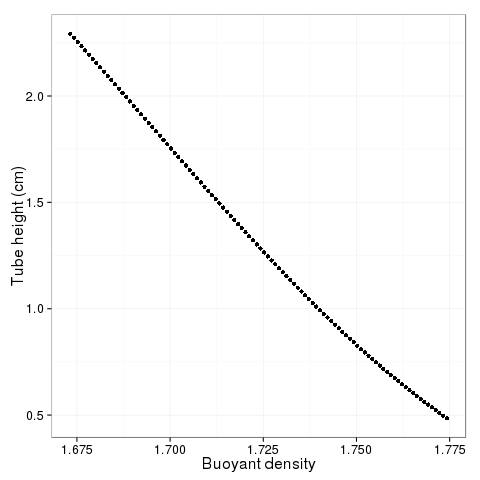

In [201]:
%%R
BD_gradient = rev(seq(min_BD, max_BD, 0.001))

# wrapper function for BD2tubeVol & tubeVol2height
BD2tubeHeight = function(BD, r){
    stopifnot(length(BD) == 1)
    v = BD2tubeVol(BD)
    tubeVol2height(v, r)    
}

h = sapply(BD_gradient, BD2tubeHeight,  r=tube_radius__cm)
df = data.frame('BD' = BD_gradient, 'height' = h)

ggplot(df, aes(BD, h)) +
    geom_point() +
    labs(x='Buoyant density',
         y='Tube height (cm)') +
    theme_bw() +
    theme(
        text = element_text(size=16)
    )

 Setting volume to 0
 Setting volume to 0
 Setting volume to 0
 Setting volume to 0
 Setting volume to 0
 Setting volume to 0


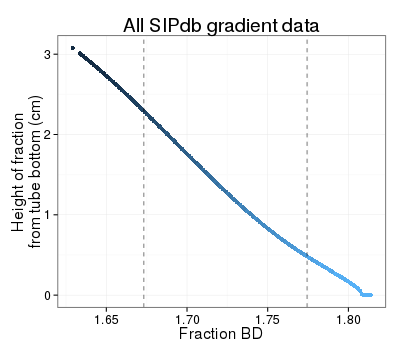

In [202]:
%%R -w 400 -h 350
# plotting relationship between BD and tube height for SIPdb data
df.SIPdb = df.SIPdb %>%
    mutate(tube_height__cm = sapply(BD, BD2tubeHeight, r=tube_radius__cm))


## plotting
ggplot(df.SIPdb, aes(BD, tube_height__cm, color=-fraction_id)) +
    #geom_point(alpha=0.5, shape='O') +
    geom_point() +
    geom_vline(xintercept=min_BD, linetype='dashed', alpha=0.5) +
    geom_vline(xintercept=max_BD, linetype='dashed', alpha=0.5) +
    labs(title='All SIPdb gradient data', 
         y='Height of fraction\nfrom tube bottom (cm)', 
         x='Fraction BD') +
    theme_bw() +
    theme(
        text = element_text(size=16),
        legend.position = 'none'
    )

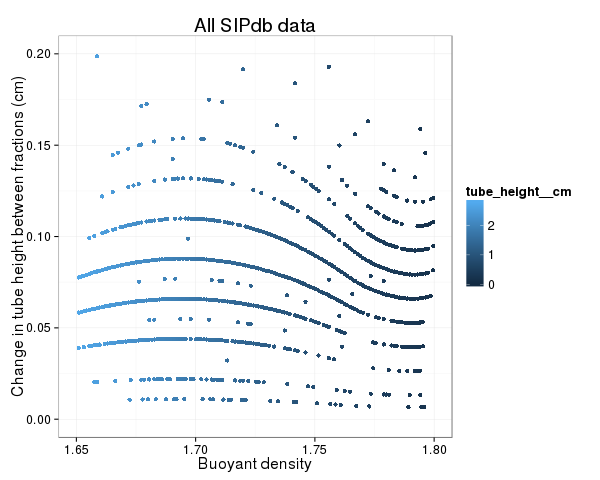

In [203]:
%%R -w 600
# do the BD bands expand further up in the gradient?

df.SIPdb = df.SIPdb %>%
    group_by(sample_id, fractionation_date) %>%
    arrange(fraction_id) %>%
    mutate(delta_tube_height = lead(tube_height__cm) - tube_height__cm) 

df.SIPdb.f = df.SIPdb %>%
    filter(delta_tube_height > 0)

ggplot(df.SIPdb.f, aes(BD, delta_tube_height, color=tube_height__cm)) +
    geom_point() +
    scale_x_continuous(limits=c(1.65, 1.80)) +
    scale_y_continuous(limits=c(0, 0.2)) +
    labs(title='All SIPdb data',
         x='Buoyant density',
         y='Change in tube height between fractions (cm)') +
    theme_bw() +
    theme(
        text = element_text(size=16)
    )

# DBL overlap in fractions 

* max delta BD between fraction in rotor orientation vs when the orientation set to verticle for fractionation

In [204]:
%%R
## df of tube position for gradient in rotor (assuming equilibrium)
angle.tube.pos %>% head(n=4)

  tube_low__cm tube_high__cm      BD particle_pos
1     1.368140      3.817911 1.67323     3.289207
2     1.326125      3.775896 1.67423     3.308901
3     1.284360      3.734131 1.67523     3.328479
4     1.242838      3.692609 1.67623     3.347942


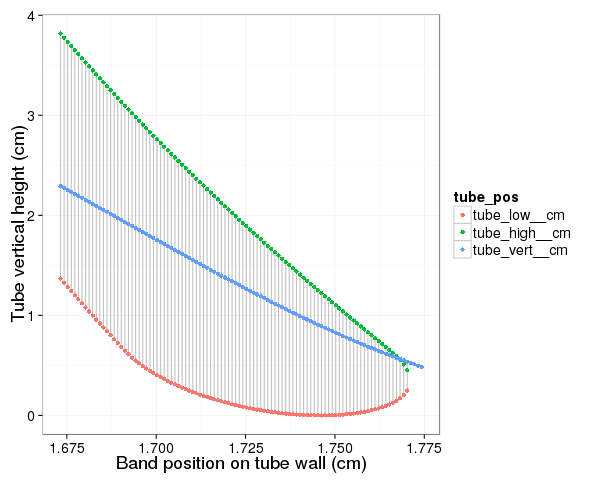

In [205]:
%%R -w 600
# converting BD to tube height for vertical gradient
angle.tube.pos$tube_vert__cm = sapply(angle.tube.pos$BD, BD2tubeHeight,  r=tube_radius__cm)

# plotting
angle.tube.pos.g = angle.tube.pos %>%
    gather(tube_pos, tube_pos__cm, tube_low__cm, tube_high__cm, tube_vert__cm)

ggplot(angle.tube.pos.g, aes(BD, tube_pos__cm, color=tube_pos, group=BD)) +
    geom_line(alpha=0.25, color='black') +
    geom_point() +
    labs(y='Tube vertical height (cm)', x='Band position on tube wall (cm)') +
    theme_bw() +
    theme(
        text = element_text(size=18)
    )

# Sandbox

In [206]:
%%R
## Libraries
library(aspace)
## Given values
r = 0.65   # radius of tube
D = 4.85   # distance from axis of rotation to furthest part of tube
A = 37.95  # angle of tube to axis of rotation (degrees)
x = 4.32    # some distance from axis of rotation (from equation)

## Equation for lower point of band in the rounded part of tube

if(x >= D-(r*cos_d(A))-r) {
  d = D - x
  hv = sqrt(d*(2*r-d))
  if (x >= D-(r-r*sin_d(A))) {
    a = (90-A)-asin_d(hv/r)
  }
  else if (x < D-(r-r*sin_d(A))) {
    a = -(90-A)-asin_d(hv/r)
  }
  LowH = r-r*cos_d(a)
  print(LowH)
}

## Equation for lower point of band in column part of tube

if(x < D-(r*cos_d(A))-r) {
 d = D-x-r
 hc = d/sin_d(A)
 LowH = r+hc
 print(LowH)
}

## Equation for upper point of band in rounded part of tube

if(x > D-(r-r*cos_d(A))) {
  d = D - x
  hv = sqrt(d*(2*r-d))
  a = (90-A)+asin_d(hv/r)
  HighH = r-r*cos_d(a)
  print(HighH)
}

## Equation for upper point of band in cylindrical part of tube
if(x <= D-(r-r*cos_d(A))) {
  d = D-(r-r*cos_d(A))-x
  hc = d/sin_d(A)
  HighH = r+hc
  print(HighH)
}


[1] 1.079949
[1] 1.28833


In [207]:
%%R
## Equation for lower point of band in the rounded part of tube
distFromAxis2angleTubePos = function(x, r, D, A){
    # x = a distance from the axis of rotation
    # r = radius of cfg tube
    # D = max tube distance from axis of rotation
    # A = angle of tube to axis of rotation (degrees)
    if(x >= D-(r*aspace::cos_d(A))-r) {
      d = D - x
      hv = sqrt(d*(2*r-d))
      if (x >= D-(r-r*aspace::sin_d(A))) {
        a = (90-A)-aspace::asin_d(hv/r)
      }
      else if (x < D-(r-r*aspace::sin_d(A))) {
        a = -(90-A)-aspace::asin_d(hv/r)
      }
      LowH = r-r*aspace::cos_d(a)
      #print(LowH)
    }
    
    ## Equation for lower point of band in column part of tube
    
    if(x < D-(r*aspace::cos_d(A))-r) {
     d = D-x-r
     hc = d/aspace::sin_d(A)
     LowH = r+hc
     #print(LowH)
    }
    
    ## Equation for upper point of band in rounded part of tube
    
    if(x > D-(r-r*aspace::cos_d(A))) {
      d = D - x
      hv = sqrt(d*(2*r-d))
      a = (90-A)+aspace::asin_d(hv/r)
      HighH = r-r*aspace::cos_d(a)
      #print(HighH)
    }
    
    ## Equation for upper point of band in cylindrical part of tube
    if(x <= D-(r-r*aspace::cos_d(A))) {
      d = D-(r-r*aspace::cos_d(A))-x
      hc = d/aspace::sin_d(A)
      HighH = r+hc
      #print(HighH)
    }
    return(c(LowH, HighH))
}

# test
r = 0.65   # radius of tube
D = 4.85   # distance from axis of rotation to furthest part of tube
A = 37.95  # angle of tube to axis of rotation (degrees)
x = 4.32    # some distance from axis of rotation (from equation)

distFromAxis2angleTubePos(x, r, D, A)

[1] 1.079949 1.288330


In [208]:
%%R
x = seq(0,3, 0.5)
r = 0.65   # radius of tube
D = 4.85   # distance from axis of rotation to furthest part of tube
A = 27.95  # angle of tube to axis of rotation (degrees)

sapply(x, distFromAxis2angleTubePos, r=r, D=D, A=A)

          [,1]     [,2]     [,3]     [,4]     [,5]     [,6]     [,7]
[1,]  9.610939 8.544161 7.477382 6.410604 5.343825 4.277047 3.210268
[2,] 10.835989 9.769211 8.702432 7.635654 6.568875 5.502097 4.435318


# Function for angled tube position

In [76]:
np.arcsin(1)

1.5707963267948966

In [77]:
%%R
asin(1)

[1] 1.570796


In [83]:
A = 1
asin_d(A)

0.017454178737585171

In [84]:
np.deg2rad(A)

0.017453292519943295

In [86]:
%%R -i A
aspace::asin_d(90)

[1] NaN


In [87]:
sin_d = lambda d : np.sin(np.deg2rad(d))    
cos_d = lambda d : np.cos(np.deg2rad(d))    
asin_d = lambda x : np.arcsin(x) * 180/np.pi  #np.arcsin(np.deg2rad(d))
acos_d = lambda x : np.arccos(x) * 180/np.pi  #np.arccos(np.deg2rad(d))

def axisDist2angledTubePos(x, tube_radius, r_max, A):
    if np.isnan(x):
        return (x, x)
    
    if(x >= r_max - (tube_radius * cos_d(A)) - tube_radius):
        # band in rounded bottom of cfg tube
        d = x - (r_max - tube_radius)
        a = A - asin_d(d / tube_radius)
        LowH = tube_radius - tube_radius * cos_d(a)
        #print LowH
    else:
        # band in cylinder of cfg tube
        d = r_max - (tube_radius * cos_d(A)) - tube_radius - x
        h_c = d/sin_d(A)
        LowH = tube_radius + h_c
        # print LowH
    
    if(x > r_max - (tube_radius - tube_radius * cos_d(A))):
        # Equation for finding the upper band
        d = x - (r_max - tube_radius)
        a = A - (180 - asin_d(d/tube_radius))
        HighH = tube_radius - tube_radius * cos_d(a)
        #print HighH
    else:
        # This band will be in the cylinder part
        d = r_max - (tube_radius - tube_radius * cos_d(A)) - x
        h_c = d/sin_d(A)
        HighH = tube_radius + h_c
        #print(HighH)
    return(LowH, HighH)

# test
r = 0.65   # radius of tube (cm)
D = 4.85   # distance from axis of rotation to furthest part of tube (cm)
A = 27.95  # angle of tube to axis of rotation (degrees)
x = 3.86    # some distance from axis of rotation (from equation)

axisDist2angledTubePos(x, r, D, A)

(0.31999130190182146, 2.6004594091294315)

In [88]:
X = np.arange(0, 5, 0.1)
axisDist2angledTubePosV = np.vectorize(axisDist2angledTubePos)
low,high = axisDist2angledTubePosV(X, r, D, A)

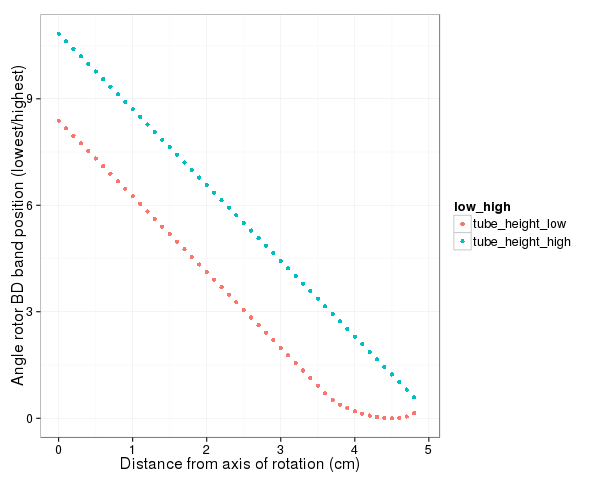

In [89]:
%%R -i X -i low -i high -w 600
X = as.numeric(X)
low = as.numeric(low)
high = as.numeric(high)
df = data.frame('axisDist' = X, 'tube_height_low' = low, 'tube_height_high' = high) %>%
    gather(low_high, height, tube_height_low, tube_height_high) #%>%

ggplot(df, aes(axisDist, height, color=low_high)) +
    geom_point() +
    labs(x = 'Distance from axis of rotation (cm)',
         y = 'Angle rotor BD band position (lowest/highest)') +
    theme_bw() +
    theme(
        text = element_text(size=16)
    )

# Function for angled tube volume

In [35]:
import numpy as np
from scipy.integrate import quad

# numpy-dependent code
def distFromAxis2angleTubeVol(x, r, A, D):
    # x = distance from axis of rotation
    # r = tube radius
    # A = tube angle
    # D = max distance from axis of rotation
    
    a = np.deg2rad(A)
    p1 = r-(r*np.cos(a))
    p2 = r+(r*np.cos(a))
    R12 = p2-p1
    d = D-x
    D1 = D-p1
    D2 = D-p2
    
    def SphVol(t, r, p2, R12):
        v1 = t*((2*r)-t)/2
        v2 = 2*np.pi*((p2-t)/R12) 
        v3 = np.sin(2*np.pi*((p2-t)/R12))
        return v1 * (v2 - v3)
        #return (t*((2*r)-t)/2) * ((2*np.pi*((p2-t)/R12)) - np.sin(2*np.pi*((p2-t)/R12)))
    
    def CylWedVol(t, r, b, h):
        return 2*(h*(t-r+b)/ b) * np.sqrt(r**2-t**2)

    if x < D2:
        h1 = (D2-x)/np.sin(a)
        h2 = (D1-x)/np.sin(a)
        volume1 = (2/3.0)*np.pi*r**3
        volume2 = (0.5)*np.pi*r**2*(h1+h2)
        volume = volume1+volume2
    elif D1 >= x >= D2:
        volume1 = (1/3.0)*np.pi*p1**2*(3*r-p1)
        volume2 = quad(SphVol, p1, d, args=(r, p2, R12))
        b = (d-p1)/np.cos(a)
        h = b/np.tan(a)
        volume3 = quad(CylWedVol, r-b, r, args=(r, b, h))
        volume = volume1+volume2[0]+volume3[0]
    elif D >= x > D1:
        volume = (1/3.0)*np.pi*d**2*(3*r-d)
    elif x > D:
        print "Cannot compute! Value is beyond end of tube."
        volume = 0.0
    return volume


# test
r = 0.65   # radius of tube (cm)
D = 4.85   # distance from axis of rotation to furthest part of tube (cm)
A = 27.95  # angle of tube to axis of rotation (degrees)
x = 3.86    # some distance from axis of rotation (from equation)

distFromAxis2angleTubeVol(x, r, A, D)

1.574998899271181

In [36]:
%Rpull r_min__mm r_max__mm

r_min = r_min__mm / 10
r_max = r_max__mm / 10
x = np.arange(r_min, r_max, 0.1)
distFromAxis2angleTubeVolV = np.vectorize(distFromAxis2angleTubeVol)
vol = distFromAxis2angleTubeVolV(x, r, A, D)

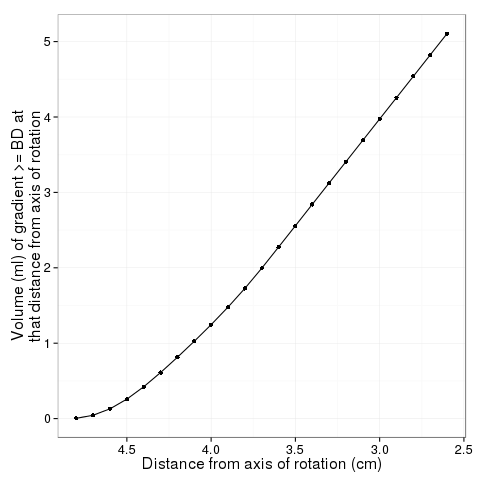

In [37]:
%%R -i x -i vol
# plotting
df = data.frame('dist_from_axis' = x, 'volume' = vol)

ggplot(df, aes(dist_from_axis, volume)) +
    geom_point() +
    geom_line() +
    scale_x_reverse() +
    labs(x = 'Distance from axis of rotation (cm)',
         y = 'Volume (ml) of gradient >= BD at\nthat distance from axis of rotation') +
    theme_bw() +
    theme(
        text = element_text(size=16)
    )

#### Notes

* Seems to be correct (or almost)
* The total volume is approx. right (should be total volume of 4.7 ml)
* The lower volumes at the rounded part of the gradient is as expected